In [1]:
import anndata
import scanpy as sc
from pandas import read_csv

In [2]:
filters = read_csv('samplesheet_scrnaseq_preprocessing.csv')

dataset_str = 'Chen_Zhang_2020_NSCLC'

id_row = filters[filters.id == dataset_str]
file_str = id_row.input_adata.iloc[0].split('/')[-1]

In [2]:
import numpy; numpy.show_config()

openblas64__info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
blas_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None)]
    runtime_library_dirs = ['/usr/local/lib']
openblas64__lapack_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None), ('BLAS_SYMBOL_SUFFIX', '64_'), ('HAVE_BLAS_ILP64', None), ('HAVE_LAPACKE', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_ilp64_opt_info:
    libraries = ['openblas64_', 'openblas64_']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None

In [3]:
thresholds = {}
thresholds['min_counts']  = int(id_row.min_counts)
thresholds['max_counts'] = int(id_row.max_counts)
thresholds['min_genes'] = int(id_row.min_genes)
thresholds['max_genes'] = int(id_row.max_genes)
thresholds['max_pct_mito'] = int(id_row.max_pct_mito)

adata = anndata.read_h5ad(f'/root/datos/maestria/netopaas/luca/data/12_input_adatas/{file_str}')

In [4]:
# very basic gene filtering - genes with 0 cells cause some downstream processes to fail.
print("Filtering genes")
print(f"    Before: {adata.shape[1]}")
sc.pp.filter_genes(adata, min_counts=3)
print(f"    After: {adata.shape[1]}")

# %%
# Apply thresholds
print("Filter by min_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_counts=thresholds["min_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_counts=thresholds["max_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by min_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_genes=thresholds["min_genes"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_genes=thresholds["max_genes"])
print(f"    After: {adata.shape[0]}")

# %%
if "mito" not in adata.var.columns:
    adata.var["mito"] = adata.var_names.str.lower().str.startswith("mt-")

# %%
sc.pp.calculate_qc_metrics(
    adata, qc_vars=("mito",), log1p=False, inplace=True, percent_top=None
)

print("Filter by max_pct_mito")
print(f"    Before: {adata.shape[0]}")
adata = adata[adata.obs["pct_counts_mito"] < thresholds["max_pct_mito"]].copy()
print(f"    After: {adata.shape[0]}")

Filtering genes
    Before: 36601
    After: 28863
Filter by min_counts
    Before: 145021
    After: 140088
Filter by max_counts
    Before: 140088
    After: 138789
Filter by min_genes
    Before: 138789
    After: 134946
Filter by max_genes
    Before: 134946
    After: 134946
Filter by max_pct_mito
    Before: 134946
    After: 131287


## 3.1.1 Automated annotation

For a more detailed walkthrough of the process go to `../HCA-Lung/AutoLung.ipynb`

In [5]:
import scarches as sca
import gdown
import gzip
import shutil

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [6]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../single-cell-tutorial/download_scripts'))
from functions import remove_repeated_var_inds, join_map_mart

### Load Query dataset

In [7]:
batch_key = 'dataset'
name = dataset_str.split('_')[0]
query_batch = [f'lung_{name}']
cell_type_key = 'scanvi_label'
data_dir = '/root/datos/maestria/netopaas/lung_scRNA'

#Important to check how many epochs would be ideal
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [8]:
adata_ref = sc.read_h5ad(f'{data_dir}/HCA_Lung/HLCA_emb_and_metadata.h5ad')

In [9]:
adata_query_unprep = adata.copy()

# We need count data for the model we are using so we get it from adata.layers
#adata_query_unprep.X = adata_query_unprep.layers['counts']

Revert to ensemble ids using the assembly reference gch38 (or hg19 in the comments) used in the experiment.
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

In [10]:
# if ('37' in metadata['genome_build'][gsm]) or ('hg19' in metadata['genome_build'][gsm]):
# host='grch37.ensembl.org'
# else:
host = 'www.ensembl.org'
annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id","external_gene_name", 'gene_biotype'],
    use_cache=True,
    host=host
)

maps_gene_names = join_map_mart(adata_query_unprep, annot)

In [11]:
maps_gene_names.isna().ensembl_gene_id.sum()
# maps_gene_names

8454

**WARNING**
- Lost 20% of genes because the biomart assembly is too generic

Chen uses:
- Chemistry 10x 3' v2
- CellRanger 3.2.0 for fastq generation
- STAR with GRCh38

I have sent an email to ask for the assembly used in STAR.
Other ideas to figure this out : 
- Figuring in what assembly some of the lost genes are
- Check the SAM/BAM Header

In [12]:
adata_query_unprep.var['ensembl_gene_id'] = maps_gene_names.ensembl_gene_id
enss = adata_query_unprep.var['ensembl_gene_id']
enss = enss.astype('string')
enss = enss.fillna('lol')
# enss = enss.astype('category')
adata_query_unprep.var.index = enss

# adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id'].astype('string')
# adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id'].fillna('lol')
# adata.var.index = adata.var['ensembl_gene_id']

adata_query_unprep = remove_repeated_var_inds(adata_query_unprep)

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [13]:
ref_model_path = f'{data_dir}/HCA_Lung/HLCA_reference_model'
# lol = sca.models.SCANVI.prepare_query_anndata(
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   
INFO     Found 86.35000000000001% reference vars in query data.                                                    


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [14]:
adata_query.obs['scanvi_label'] = 'unlabeled'

### Surgery

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [15]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

We can load the model with this command or train it if we havent got it

In [16]:
adata_query.obs['dataset'] = adata_query.obs['sample']
adata_query.obs['sample'] = adata_query.obs['sample'].astype('string')
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')

In [17]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


In [ ]:
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 266/500:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 265/500 [4:00:56<148:01:28, 2267.61s/it, loss=499, v_num=1]

In [105]:
surgery_model.save(f'surgeries/{name}', overwrite=True)

In [18]:
surgery_model = sca.models.SCANVI.load(f'surgeries/{name}/', adata_query)

INFO     File surgeries/Chen/model.pt already downloaded                                                           


### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [19]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

In [20]:
adata_query_latent.write_h5ad(f'surgeries/latent_{name}.h5ad')

In [21]:
adata_query_latent = sc.read_h5ad(f'surgeries/latent_{name}.h5ad')

### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [22]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [23]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [26]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'surgeries/combined_{name}.h5ad')

In [10]:
combined_emb = sc.read_h5ad(f'surgeries/combined_{name}.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [24]:
celltypes = f'{data_dir}/HCA_Lung/HLCA_celltypes_ordered.csv'

In [25]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
gdown.download(url, celltypes, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv
5.81kB [00:00, 35.9MB/s]                                                                                                                                                                                                                                                                  


'/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv'

In [26]:
import pandas as pd
cts_ordered = pd.read_csv(celltypes,index_col=0)

In [27]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)



Weighted KNN with n_neighbors = 50 ... 

I have yet to figure out how to get the number of threads openblas was configured with. 
For now I just try out differentnumbers until ther is no warning

In [28]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '40'

In [1]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

NameError: name 'sca' is not defined

With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [30]:
uncertainty_threshold = 0.2

In [31]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [32]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [33]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [ ]:
def remove_uncert_types(combined_emb):
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [35]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 32.67%
Level 2: 35.76%
Level 3: 61.02%
Level 4: 69.93%
Level 5: 69.93%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

In [ ]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

In [ ]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

In [ ]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

<a id="Markers"></a>

In [ ]:
# Normalize the counts to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# Logarithmize the data
sc.pp.log1p(adata)

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.3)
# Visualize the PCA result
sc.pl.pca(adata, color='leiden')

/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


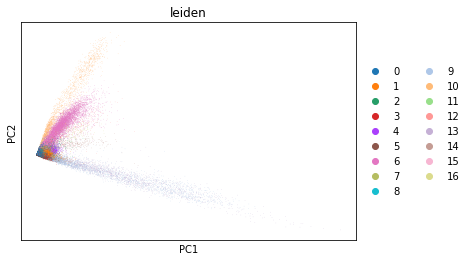

In [8]:
sc.pl.pca(adata, color='leiden')

In [ ]:
adata.write_h5ad(f'/root/datos/maestria/netopaas/luca/data/pcas/{file_str}')